In [68]:
import os
import csv
import struct
import numpy as np
import math
from scipy.interpolate import interp1d, CubicSpline
import matplotlib.pyplot as plt
from typing import List, Tuple
from numpy.core import ndarray

In [67]:
# forma d'onda normalizzata:
# in ampiezza dividendo per amplitude
# in durata facendo la spline su un numero fisso di campioni
def backup_normalize(event:ndarray, stereotype_length = 35) -> ndarray:
    ev_len = event.size
    normalizing_factor = abs(get_peak(event).min())
    x = [x for x in range(ev_len)]
    x_norm = np.linspace(0, ev_len-1, stereotype_length*3+4)
    f = interp1d(x, event/normalizing_factor)
    event_norm = f(x_norm)
    return event_norm[stereotype_length+3:2*stereotype_length+2]

In [42]:
show_plots = True
show_events_plots = True


event_stereotype_file_path = '/home/luca/py-scripts/event_stereotype_stored'
# event_stereotype_file_path =  os.path.join("C:\\","Users", "Luca Rossi", "Desktop","py-scripts", "event_stereotype_stored")

root_folder = r"/home/luca/Desktop/SARS-CoV"
# root_folder = os.path.join("C:\\","Users", "Luca Rossi", "Desktop", "extracted events")
event_folders = [root_folder + os.sep + d for d in os.listdir(root_folder)]

In [3]:
def open_dat(filename):
    f = open(filename, "rb")
    f_cont = f.read()
    f.close()
    raw = struct.unpack("d" * (len(f_cont) // 8), f_cont)
    return np.array(raw)

In [44]:
def get_peak(event: ndarray) -> ndarray:
    return event[event.size//5*2: event.size//5*3]

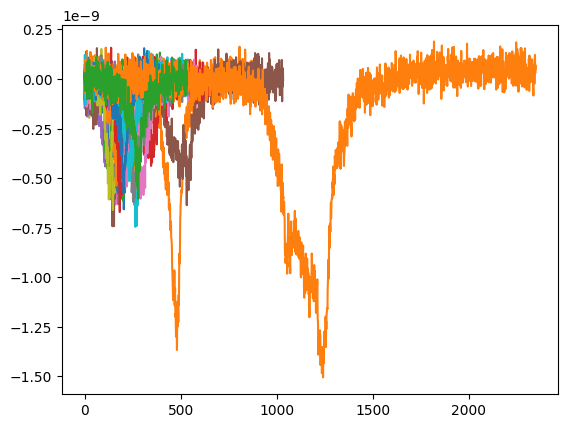

In [34]:
def view_dat(filename):
    raw = open_dat(filename)
    plt.plot(raw)
    plt.show
folder = "/home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_001"
# view_dat()
evs = extract_events(folder)
plot(evs)

In [5]:
def extract_lengths(filename):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        events_lengths = []
        for row in csv_reader:
            if len(row) > 1:
                if line_count > 1:
                    events_lengths.append(int(row[1]) - int(row[0]))
            line_count+=1
        return events_lengths

In [6]:
def extract_events(dir_name) -> List[ndarray]:
    files = os.listdir(dir_name)
    experiment_name = dir_name
    dat_file = [dir_name + os.sep + f for f in files if f.endswith(".dat")].pop()
    details_file = [dir_name + os.sep + f for f in files if f.endswith(".csv")].pop()
    # caricamento eventi dal singolo file    
    loaded_events = open_dat(dat_file)
    # caricamento dettagli file
    events_length = extract_lengths(details_file)
    
    events = []
    b = 0
    for ev_len in events_length:
        e = b + ev_len
        event = np.array(loaded_events[b:e])
        b = e
        events.append(event)
    return events

In [7]:
def remove_short_events(events: List[ndarray]) -> List[ndarray]:
    return [e for e in events if e.size > 35]

In [8]:
def remove_noisy_events(events: List[ndarray]) -> List[ndarray]:
    return [e for e in events if abs(e.min()) - abs(e.max()) > 0.1 * abs(e.min())]

In [9]:
# durata dal momento in cui l'evento supera la percentuale x dell'escursione
# al momento in cui torna al di sotto della percentuale x dell'escursione
def duration_x(event: ndarray, baseline, amplitude, percentage):
    event_x = np.nonzero(event < baseline - amplitude * percentage )[0]
    # istante in cui l'evento supera la percentuale x dell'escursione
    begin_x = event_x[0]
    # istante in cui l'evento torna al di sotto della percentuale x dell'escursione
    end_x = event_x[-1]
    return end_x - begin_x

In [10]:
# calcolo la baseline sul primo 20% del primo quinto dei dati e
# sull'ultimo 20% dell'ultimo quinto dei dati
def calc_baseline(event: ndarray) -> float:
    ev_len = event.size
    x_baseline = np.concatenate((event[:round(ev_len/5*0.2)], event[round(ev_len - ev_len/5*0.2):]))
    return np.mean(x_baseline)

In [71]:
# forma d'onda normalizzata:
# in ampiezza dividendo per amplitude
# in durata facendo la spline su un numero fisso di campioni
def normalize(event:ndarray, amplitude, stereotype_length = 35) -> ndarray:
    ev_len = event.size
    x = [x for x in range(ev_len)]
    x_norm = np.linspace(0, ev_len-1, stereotype_length*3+4)
    f = interp1d(x, event/amplitude, kind='cubic')
    event_norm = f(x_norm)
#     print("event normalized len ")
#     print(len(event_norm))
    return event_norm[stereotype_length+3:2*stereotype_length+2]
#     return event_norm

In [65]:
def extract_features(events_to_process: List[ndarray]) -> List[Tuple[float,float,float,float,ndarray]]:
    features = []
    for event in events_to_process:
        peak = get_peak(event).min()
        baseline = calc_baseline(event)
        amplitude = baseline - peak
        d50 = duration_x(event, baseline, amplitude, 0.5)
        normalized_event = normalize(event, amplitude)
        if normalized_event.max() < 0.2:
            features.append((peak, baseline, amplitude, d50, normalized_event))
    return features

In [13]:
def plot(events: List[ndarray], name = None):
    fig, ax = plt.subplots()
    if name is not None:
        ax.set_title(name)
    for e in events:
        ax.plot(e)
    plt.show()

In [14]:
def different_plot(events: List[ndarray], name = None):
    for e in events:
        fig, ax = plt.subplots()
        if name is not None:
            ax.set_title(name)
        ax.plot(e)
    plt.show()

In [15]:
def plot_features(features: List[Tuple[float,float,float,float,ndarray]], name = None):
    fig, ax = plt.subplots()
    if name is not None:
        ax.set_title(name)
    for f in features:
        _, _, _, _, n = f
        ax.plot(n)
    plt.show()

In [16]:
def debug_stuff(dir_name):
    print("extracting events from "+dir_name)
    events = extract_events(dir_name)
    print("events are " + str(len(events)))
    print("removing short events")
    events = remove_short_events(events)
    print("events are " + str(len(events)))
    print("removing noisy events")
    events = remove_noisy_events(events)
    print("events are " + str(len(events)))
    print("plotting events")
    plot(events, dir_name)
    print("extracting features")
    features = extract_features(events)
    print("plotting normalized events")
    plot([f[-1] for f in features])

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_006
events are 23
removing short events
events are 23
removing noisy events
events are 23
plotting events


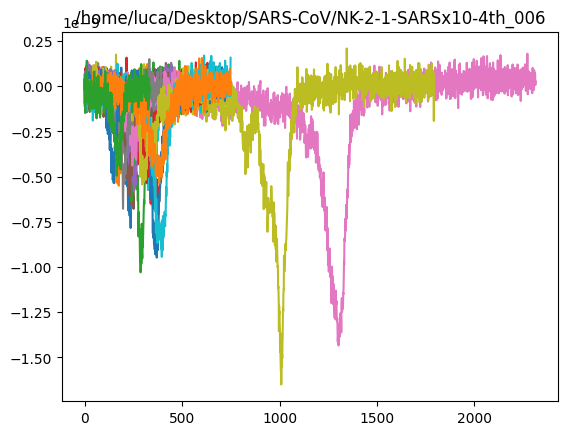

extracting features
plotting normalized events


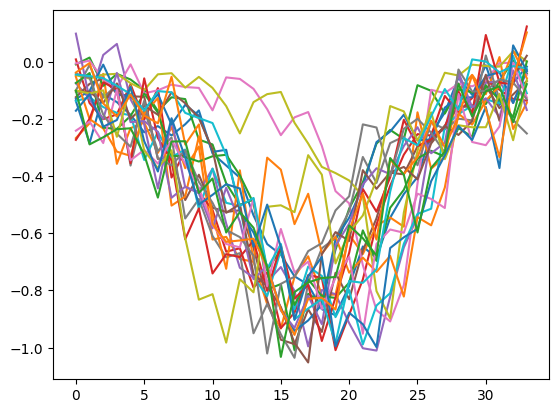

In [72]:
#testing stuff
first_measurement_dir = event_folders[0]
debug_stuff(first_measurement_dir)

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_006
events are 23
removing short events
events are 23
removing noisy events
events are 23
plotting events


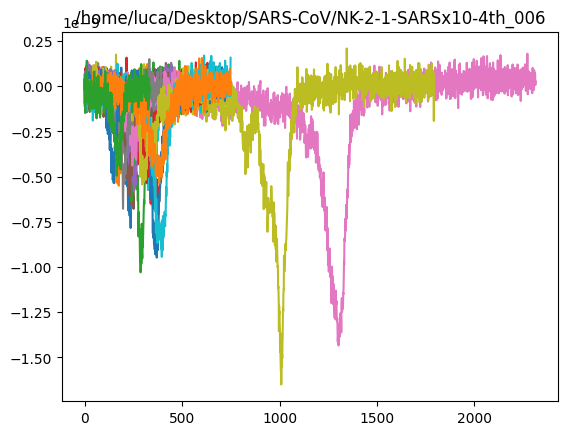

extracting features
plotting normalized events


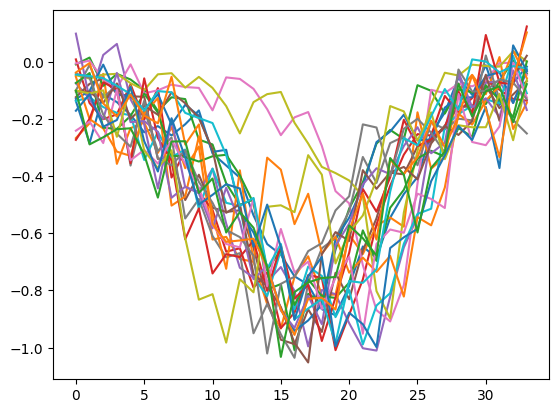

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-1st_003
events are 11
removing short events
events are 10
removing noisy events
events are 10
plotting events


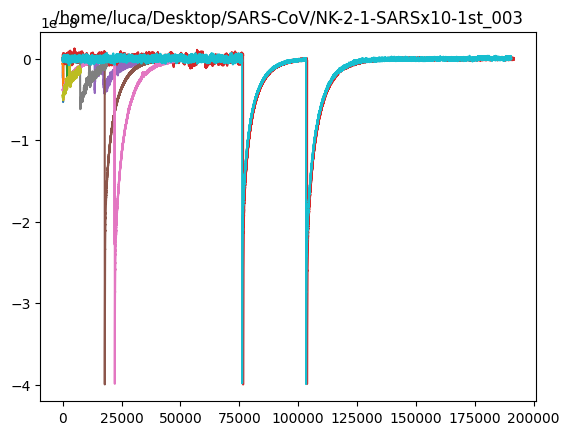

extracting features
plotting normalized events


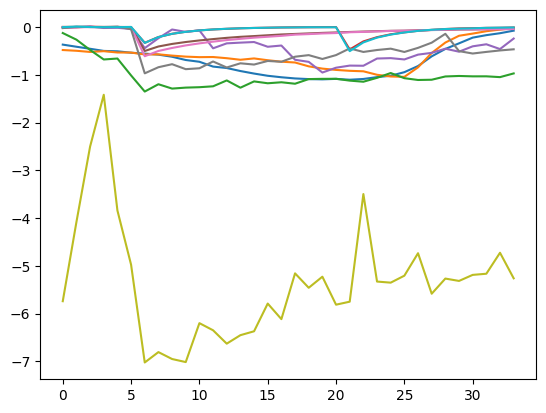

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_008
events are 47
removing short events
events are 47
removing noisy events
events are 19
plotting events


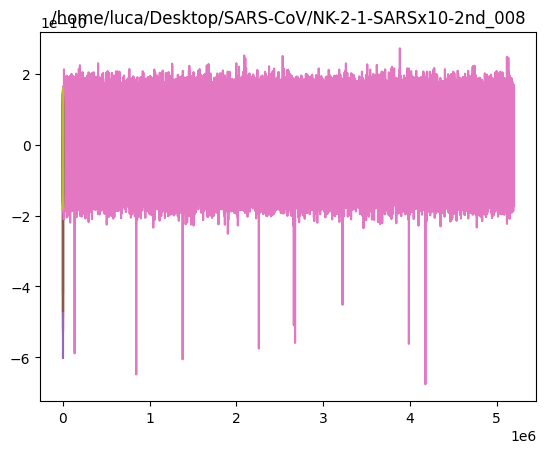

extracting features
plotting normalized events


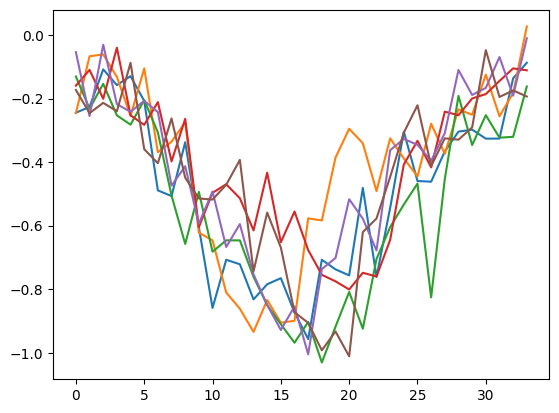

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_007
events are 42
removing short events
events are 18
removing noisy events
events are 18
plotting events


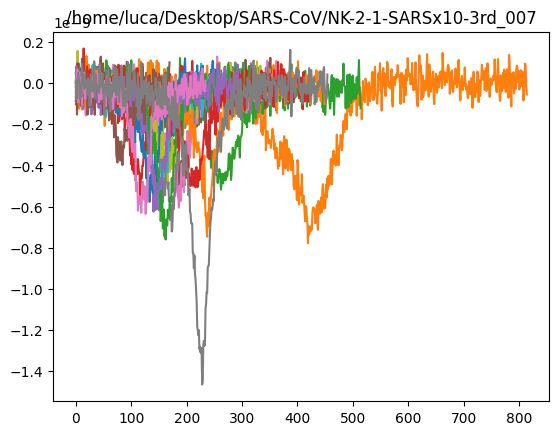

extracting features
plotting normalized events


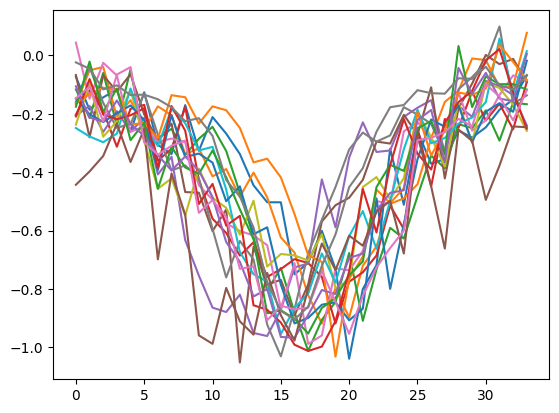

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-1st_004
events are 4
removing short events
events are 4
removing noisy events
events are 4
plotting events


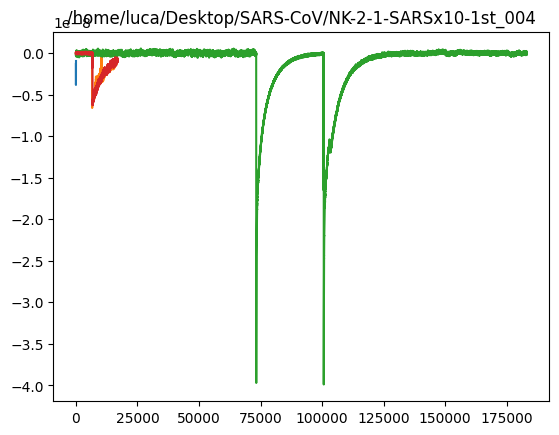

extracting features
plotting normalized events


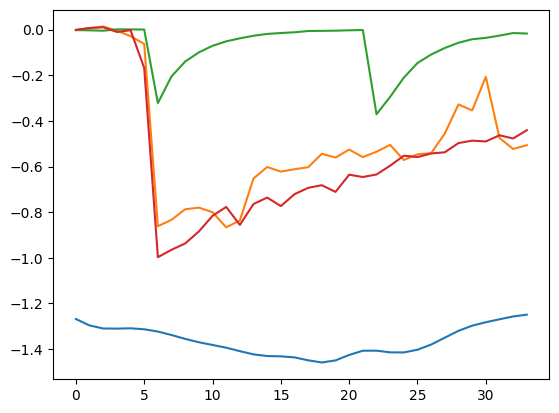

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_004
events are 47
removing short events
events are 47
removing noisy events
events are 47
plotting events


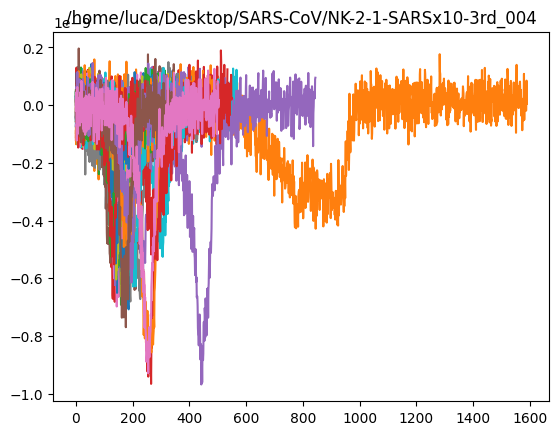

extracting features
plotting normalized events


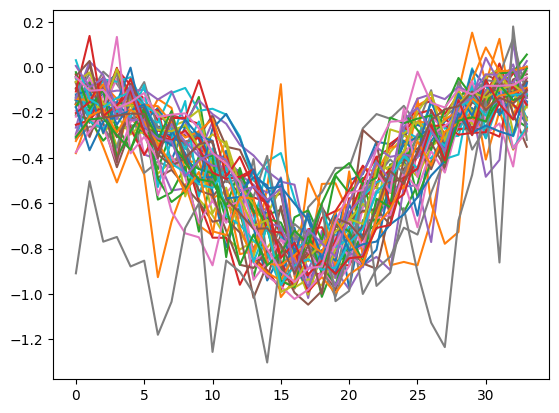

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-1st_001
events are 150
removing short events
events are 101
removing noisy events
events are 96
plotting events


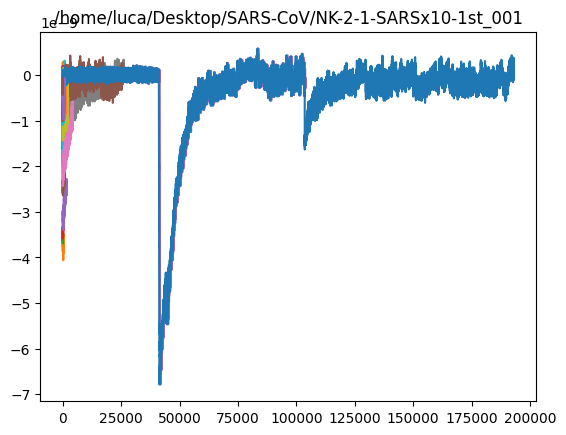

extracting features
plotting normalized events


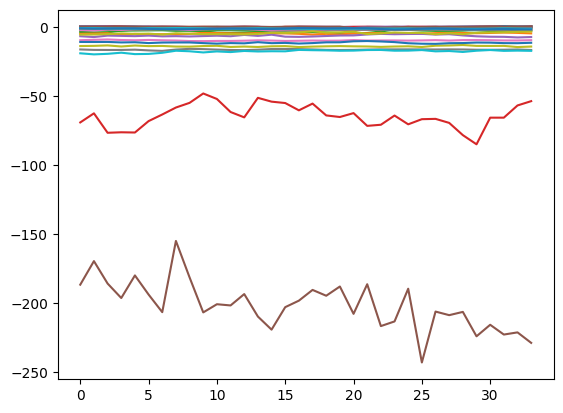

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_001
events are 28
removing short events
events are 27
removing noisy events
events are 27
plotting events


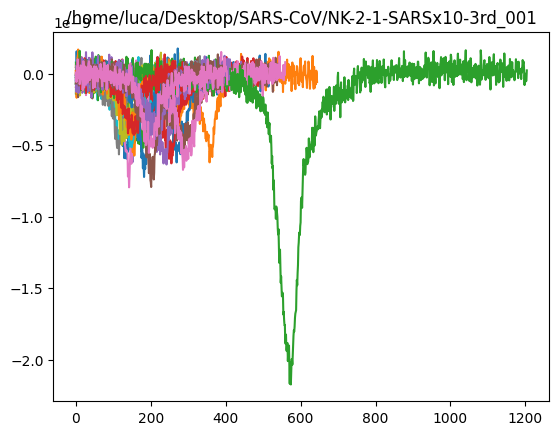

extracting features
plotting normalized events


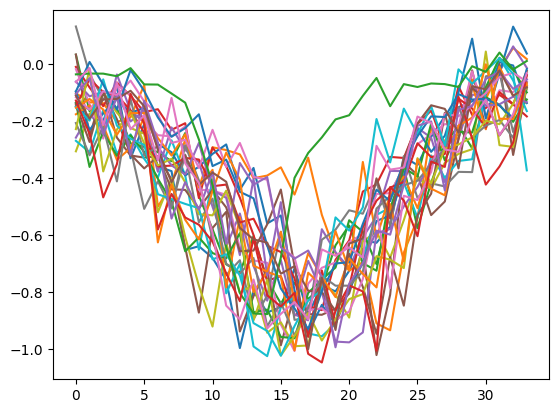

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_005
events are 40
removing short events
events are 40
removing noisy events
events are 40
plotting events


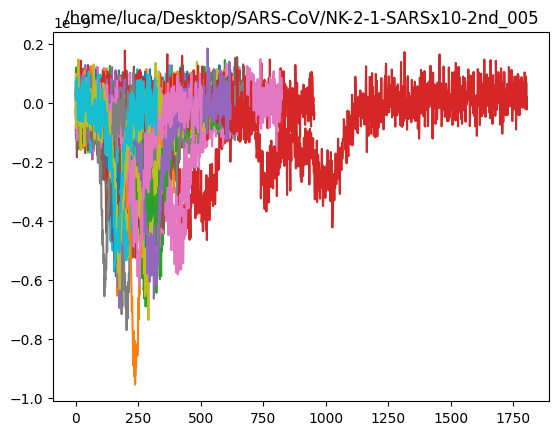

extracting features
plotting normalized events


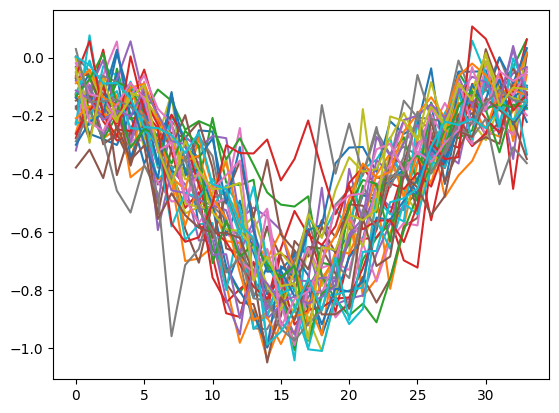

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_008
events are 34
removing short events
events are 34
removing noisy events
events are 32
plotting events


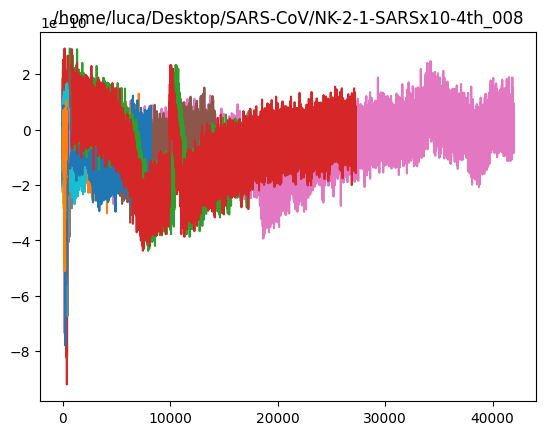

extracting features
plotting normalized events


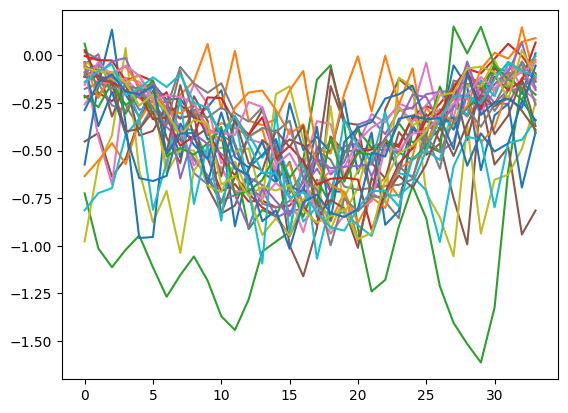

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_003
events are 38
removing short events
events are 38
removing noisy events
events are 38
plotting events


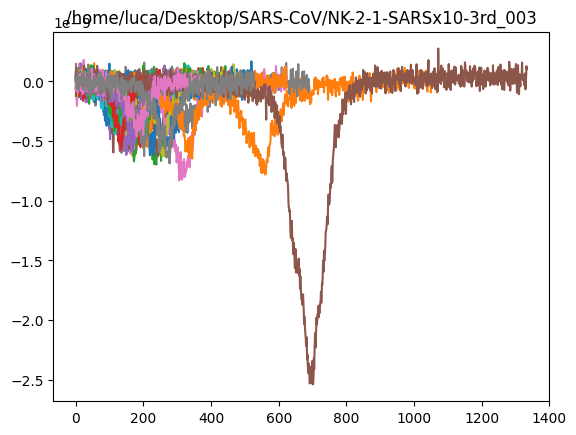

extracting features
plotting normalized events


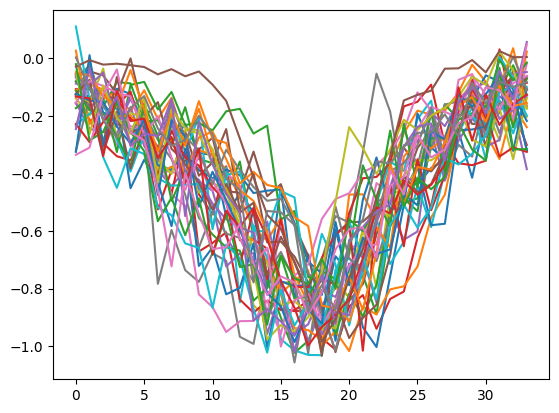

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-1st_002
events are 4
removing short events
events are 4
removing noisy events
events are 4
plotting events


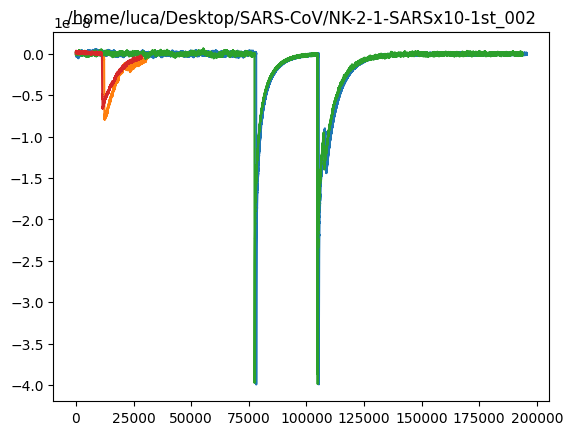

extracting features
plotting normalized events


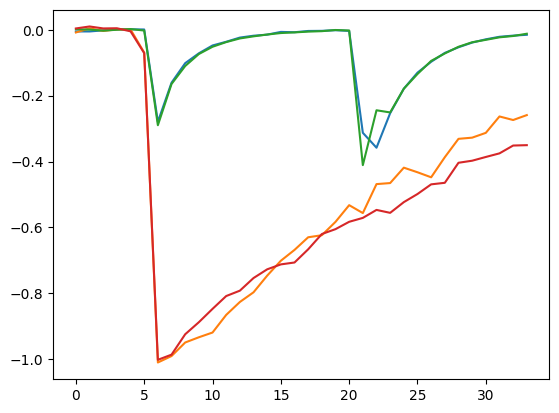

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_006
events are 34
removing short events
events are 34
removing noisy events
events are 34
plotting events


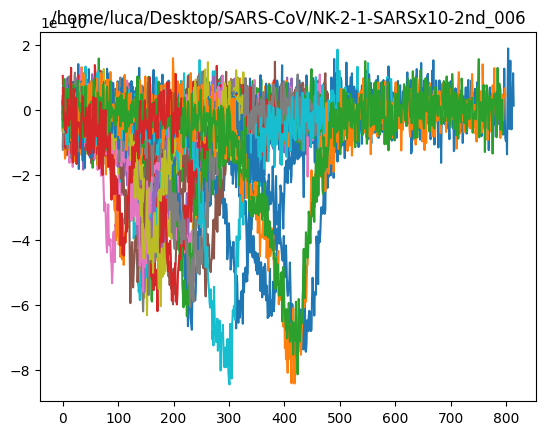

extracting features
plotting normalized events


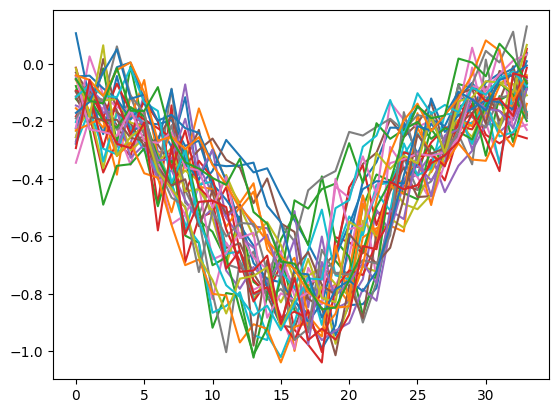

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_007
events are 57
removing short events
events are 56
removing noisy events
events are 56
plotting events


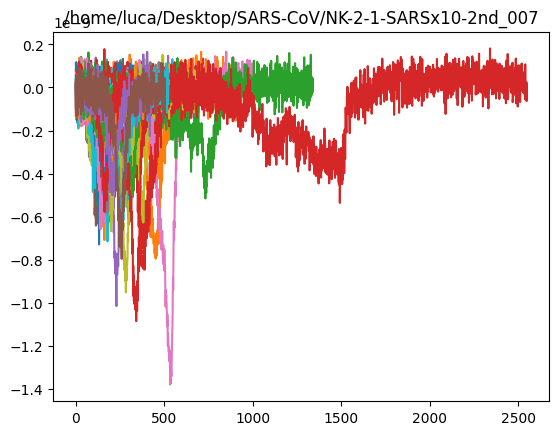

extracting features
plotting normalized events


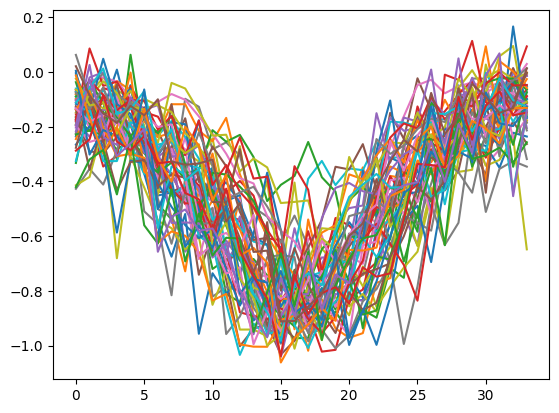

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_003
events are 34
removing short events
events are 34
removing noisy events
events are 34
plotting events


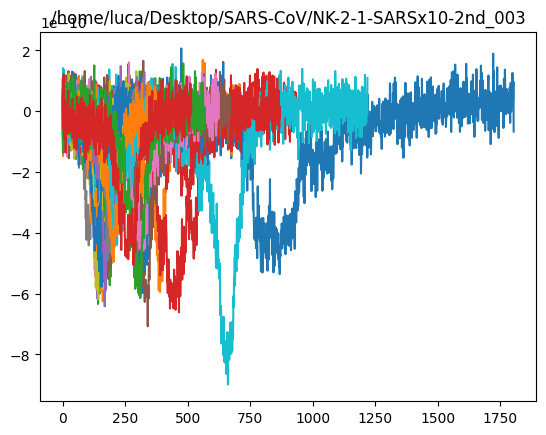

extracting features
plotting normalized events


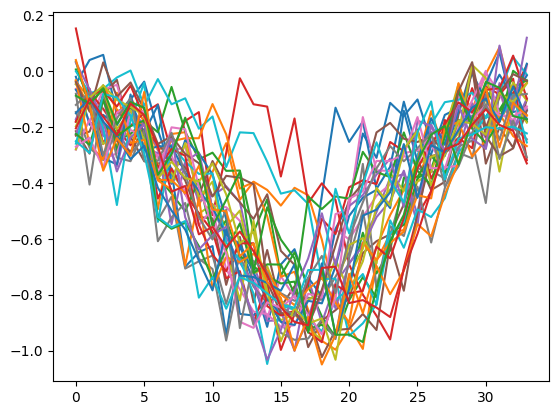

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_005
events are 40
removing short events
events are 40
removing noisy events
events are 40
plotting events


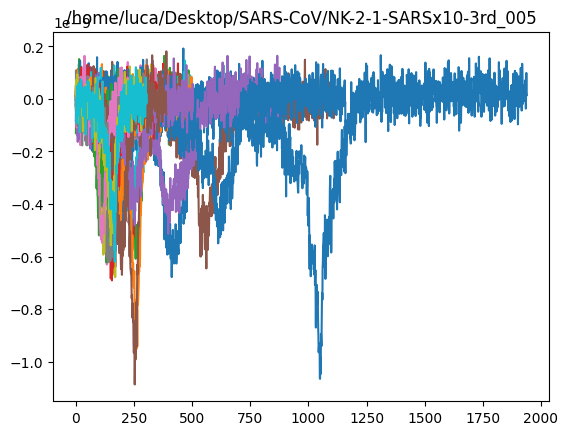

extracting features
plotting normalized events


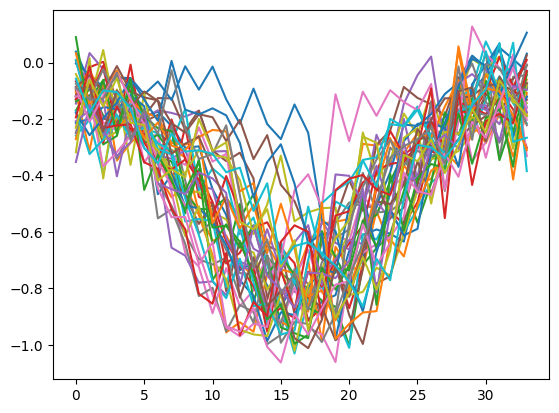

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_001
events are 18
removing short events
events are 18
removing noisy events
events are 18
plotting events


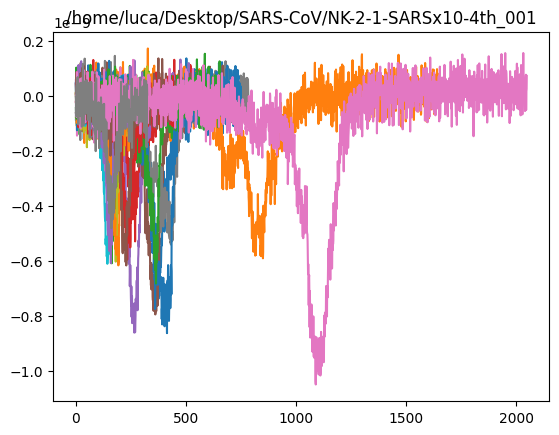

extracting features
plotting normalized events


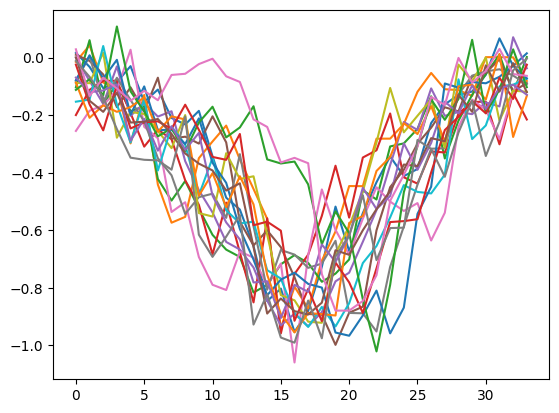

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_007
events are 30
removing short events
events are 24
removing noisy events
events are 24
plotting events


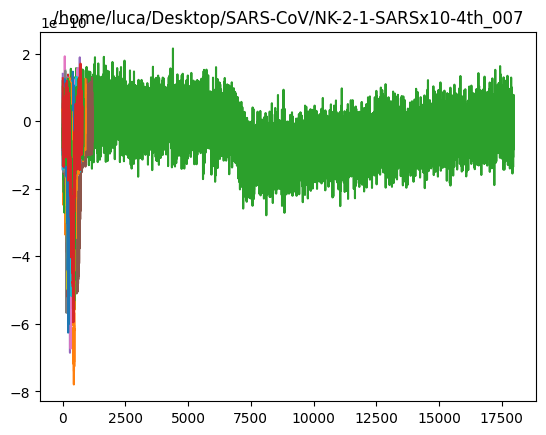

extracting features
plotting normalized events


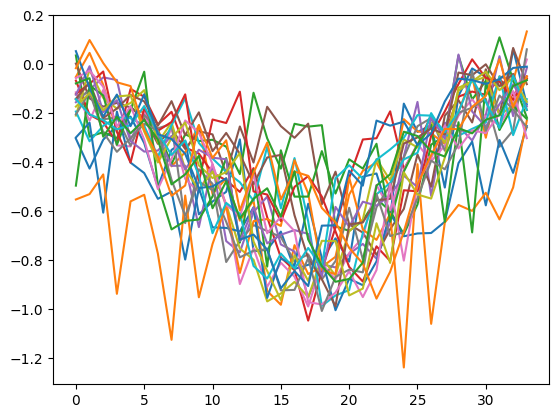

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_004
events are 44
removing short events
events are 44
removing noisy events
events are 44
plotting events


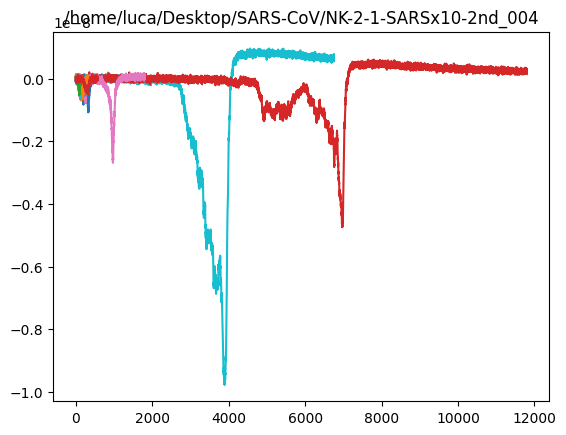

extracting features
plotting normalized events


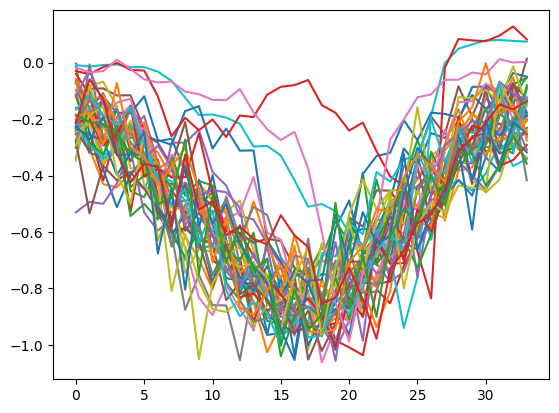

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_009
events are 3
removing short events
events are 3
removing noisy events
events are 3
plotting events


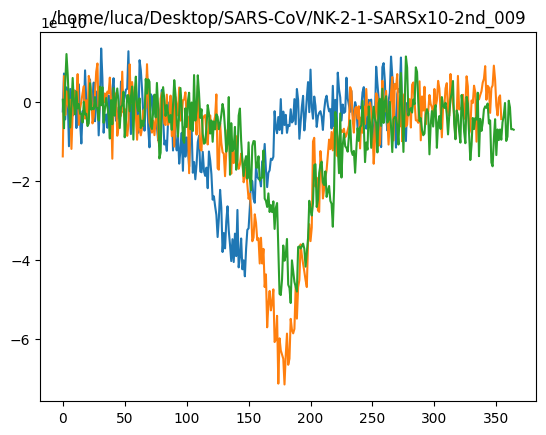

extracting features
plotting normalized events


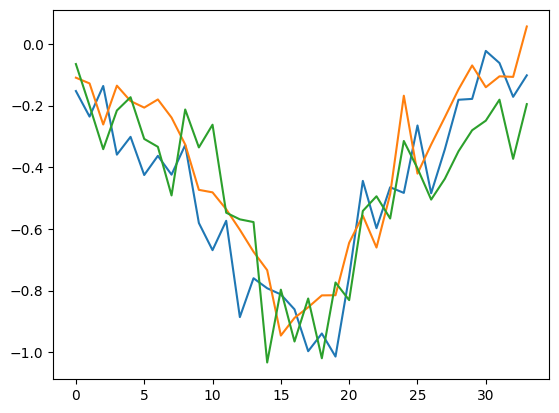

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_001
events are 33
removing short events
events are 33
removing noisy events
events are 33
plotting events


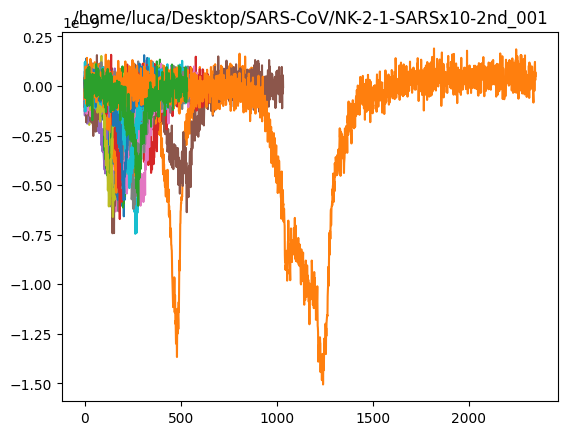

extracting features
plotting normalized events


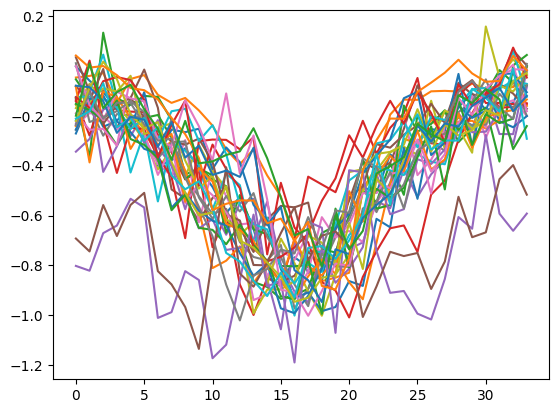

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_004
events are 21
removing short events
events are 21
removing noisy events
events are 21
plotting events


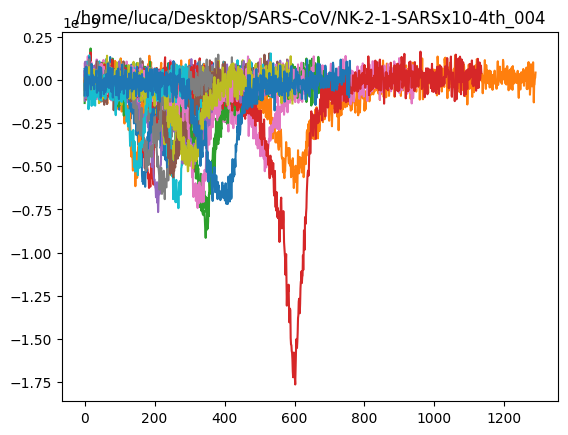

extracting features
plotting normalized events


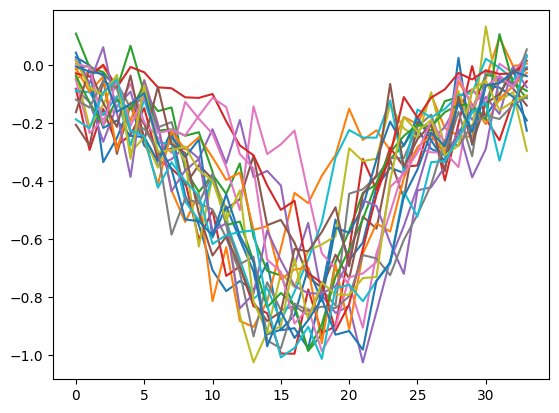

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_002
events are 29
removing short events
events are 29
removing noisy events
events are 29
plotting events


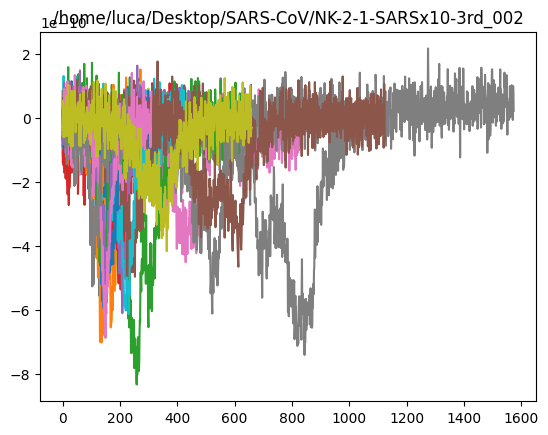

extracting features
plotting normalized events


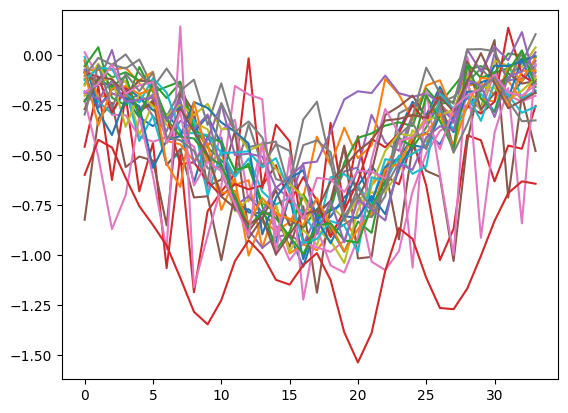

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-2nd_002
events are 49
removing short events
events are 49
removing noisy events
events are 49
plotting events


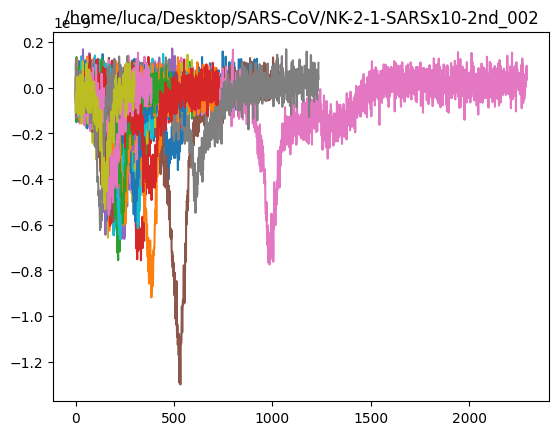

extracting features
plotting normalized events


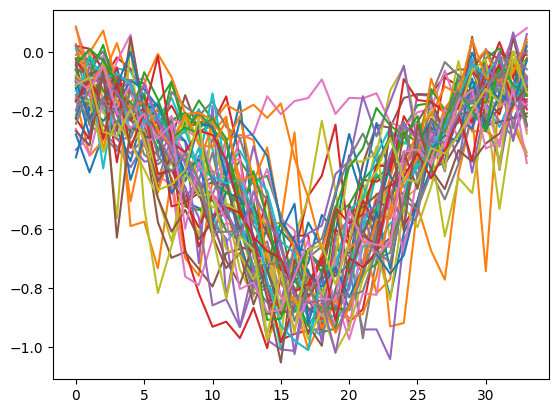

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-4th_002
events are 25
removing short events
events are 18
removing noisy events
events are 18
plotting events


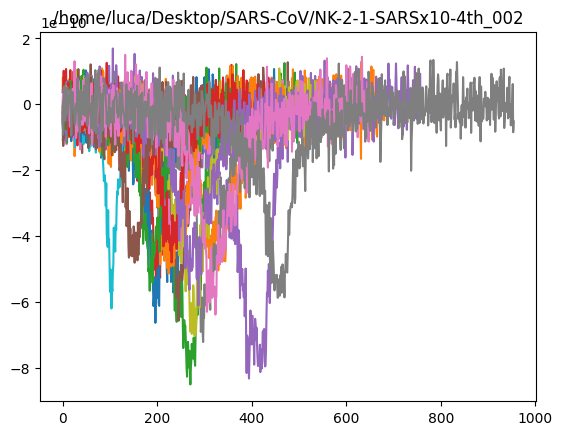

extracting features
plotting normalized events


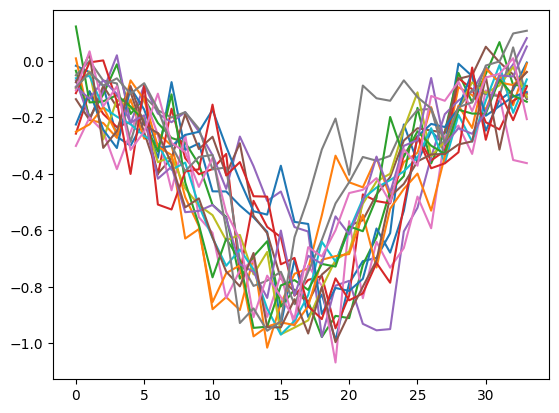

extracting events from /home/luca/Desktop/SARS-CoV/NK-2-1-SARSx10-3rd_006
events are 37
removing short events
events are 37
removing noisy events
events are 37
plotting events


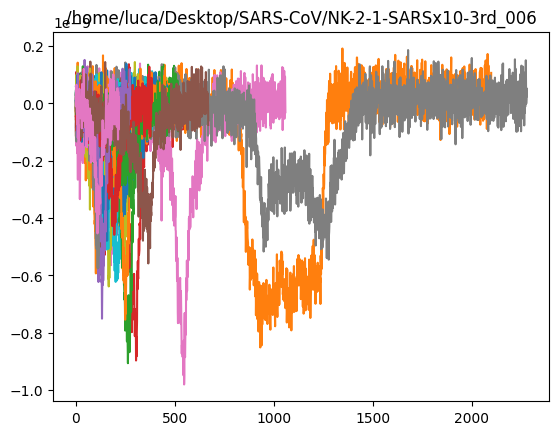

extracting features
plotting normalized events


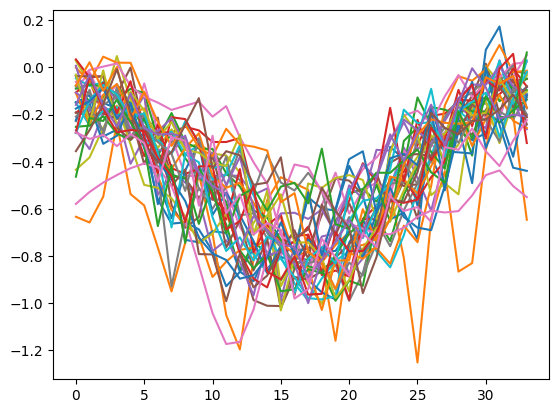

In [70]:
for measurement in event_folders:
    debug_stuff(measurement)